In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imutils

from numpy.random import default_rng
from google.colab.patches import cv2_imshow
from skimage import io
from skimage import color
from PIL import Image
from scipy import ndimage

In [ ]:
data_directory = "../path/..."

In [ ]:
image_files = [f for f in os.listdir(data_directory) if f.endswith('.jpg')]

images = {}
gold_masks = {}
gold_cells = {}
foreground_masks = {}
metrics = {}

image_keys = ['im1', 'im2', 'im3']

In [ ]:
for image_file in image_files:
    base_name = image_file[:-4]

    image_path = os.path.join(data_directory, image_file)
    gold_mask_path = os.path.join(data_directory, base_name + "_gold_mask.txt")
    gold_cells_path = os.path.join(data_directory, base_name + "_gold_cells.txt")

    images[base_name] = cv.imread(image_path)
    gold_masks[base_name] = np.loadtxt(gold_mask_path)
    gold_cells[base_name] = np.loadtxt(gold_cells_path, dtype='uint16')

In [ ]:
def image_filtering(image, kernel_size=(5, 5)):
    image = cv.GaussianBlur(image, kernel_size, 0)
    image_r_ch = image[:, :, 0]

    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    log_image = cv.filter2D(image_r_ch, cv.CV_32F, kernel)
    log_image = np.absolute(log_image)

    sharp = np.float32(image_r_ch)
    res_image = sharp + 2 * log_image

    res_image = np.clip(res_image, 0, 255).astype('uint8')
    white_limit = np.mean(image_r_ch)
    return res_image, white_limit

In [ ]:
def generate_fg_mask(image, white_limit):
    _, fg_mask = cv.threshold(image, white_limit, 255, cv.THRESH_BINARY)

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    fg_mask = cv.morphologyEx(fg_mask, cv.MORPH_OPEN, kernel, iterations=4)
    fg_mask = cv.morphologyEx(fg_mask, cv.MORPH_CLOSE, kernel, iterations=13)

    fg_mask[fg_mask == 255] = 1
    return fg_mask

In [ ]:
for key, img in images.items():
    img, limit = image_filtering(img)
    foreground_masks[key] = generate_fg_mask(img, limit)

In [ ]:
def im_plot(org_im, foreground_mask, gold_mask, file_name):
    fig = plt.figure()
    fig.set_size_inches(20, 10)

    fig.add_subplot(131)
    plt.title('Original Image')
    plt.imshow(cv.cvtColor(org_im, cv.COLOR_BGR2RGB))

    fig.add_subplot(132)
    plt.title('Foreground Mask')
    plt.set_cmap('gray')
    plt.imshow(foreground_mask)

    fig.add_subplot(133)
    plt.title('Gold Mask')
    plt.set_cmap('gray')
    plt.imshow(gold_mask)

    save_file= file_name + '.png'
    plt.savefig(save_file)

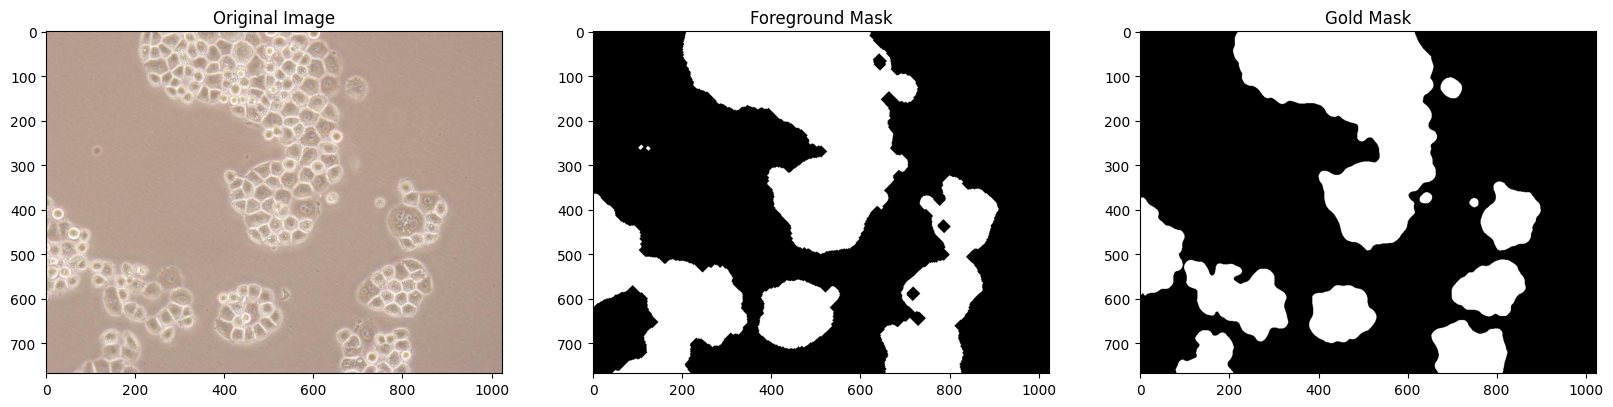

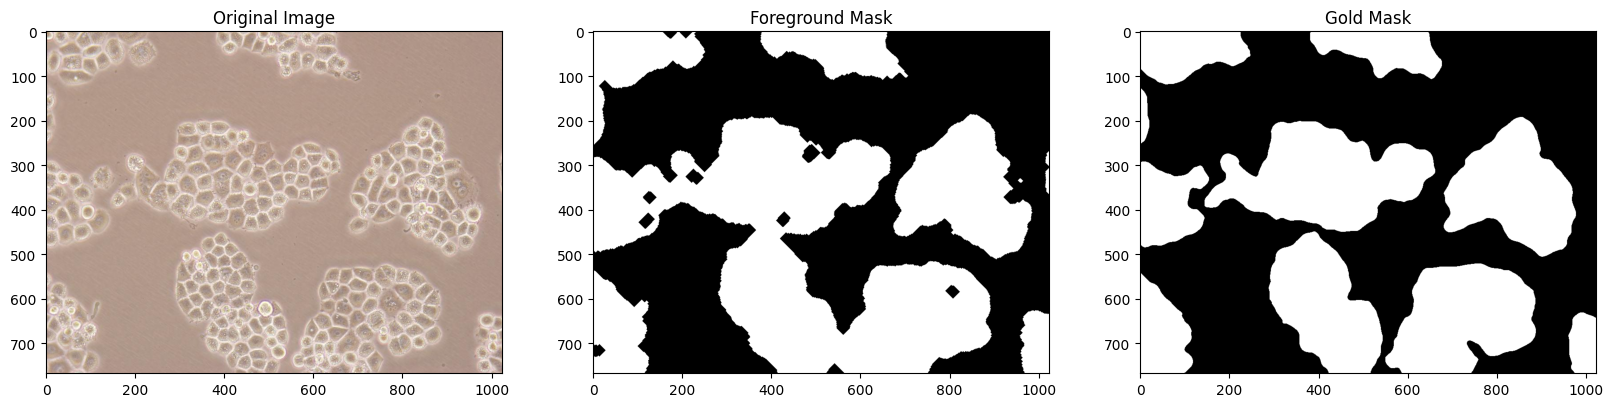

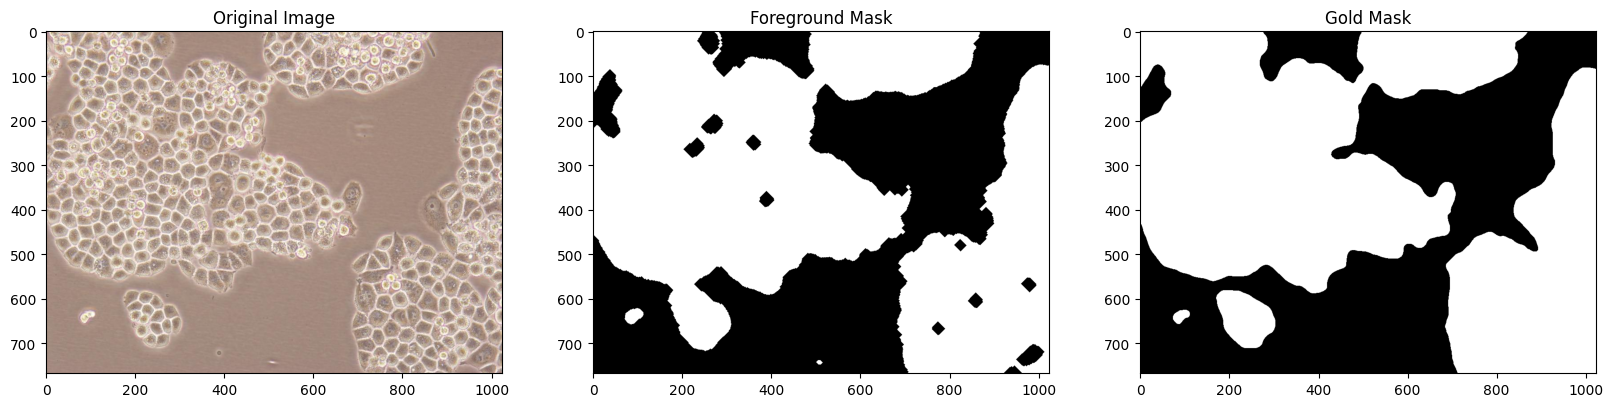

In [ ]:
im_plot(images['im1'], foreground_masks['im1'], gold_masks['im1'], "im1_comp")
im_plot(images['im2'], foreground_masks['im2'], gold_masks['im2'], "im2_comp")
im_plot(images['im3'], foreground_masks['im3'], gold_masks['im3'], "im3_comp")

In [ ]:
def evaluation_metrics(ground_truth_mask, foreground_mask):
    # true-positive
    TP = np.logical_and(foreground_mask, ground_truth_mask).sum()

    # false-positive
    FP = np.logical_and(foreground_mask, np.logical_not(ground_truth_mask)).sum()

    # true-negative
    FN = np.logical_and(np.logical_not(foreground_mask), ground_truth_mask).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [ ]:
for key in image_keys:
    precision, recall, f1_score = evaluation_metrics(gold_masks[key], foreground_masks[key])
    metrics[key] = {'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}
    print(f"Metrics for {key}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print()

Metrics for im1:
Precision: 0.8044
Recall: 0.9921
F1 Score: 0.8884

Metrics for im2:
Precision: 0.8878
Recall: 0.9773
F1 Score: 0.9304

Metrics for im3:
Precision: 0.9592
Recall: 0.9633
F1 Score: 0.9612



In [ ]:
def xy_image(xy, shape):
  image = np.zeros(shape, 'uint8')
  for center in xy:
    image[center] = 1
  return image

In [ ]:
def find_center(c):
  M = cv.moments(c)
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  return (cY, cX)

def find_cell_locs(image, mask):
  mask[mask == 1] = 255
  image = cv.GaussianBlur(image, (5,5), 0)
  masked_image = cv.bitwise_and(image, image, mask = mask)

  image_r_ch = masked_image[:,:,0]

  kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
  log_image = cv.filter2D(image_r_ch, cv.CV_32F, kernel)

  log_image = np.absolute(log_image)
  sharp = np.float32(image_r_ch)
  res_image = sharp - log_image

  res_image = np.clip(res_image, 0, 255)
  res_image = res_image.astype('uint8')
  log_image = np.clip(log_image, 0, 255)
  log_image = log_image.astype('uint8')

  _, fg_mask = cv.threshold(res_image, 140, 255, cv.THRESH_BINARY)

  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
  fg_mask = cv.morphologyEx(fg_mask, cv.MORPH_OPEN, kernel, iterations = 2)

  cells = cv.bitwise_not(fg_mask, mask = mask)

  dist = cv.distanceTransform(cells, cv.DIST_L2, 3)
  cv.normalize(dist, dist, 0, 255, cv.NORM_MINMAX)

  dist = cv.erode(dist, kernel, iterations = 3)
  dist = cv.morphologyEx(dist, cv.MORPH_OPEN, kernel, iterations = 3)

  _, fg_mask = cv.threshold(dist, 1, 255, cv.THRESH_BINARY)

  fg_mask = fg_mask.astype('uint8')

  cnts = cv.findContours(fg_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  xy = [find_center(c) for c in cnts]

  return xy, dist

In [ ]:
results = {}
xy_images = {}

for key, img in images.items():
    mask = foreground_masks[key]
    coordinates, distances = find_cell_locs(img, mask)

    results[key] = (coordinates, distances)

    xy_image_version = xy_image(coordinates, distances.shape)
    xy_images[key] = xy_image_version

In [ ]:
def im_plot_gr_cell(org_im, foreground_mask, gold_mask, file_name):
    fig = plt.figure()
    fig.set_size_inches(20, 10)

    fig.add_subplot(131)
    plt.title('Original Image')
    plt.imshow(cv.cvtColor(org_im, cv.COLOR_BGR2RGB))

    fig.add_subplot(132)
    plt.title('Gold Cell')
    plt.set_cmap('gray')
    plt.imshow(foreground_mask)

    fig.add_subplot(133)
    plt.title('Distance')
    plt.set_cmap('gray')
    plt.imshow(gold_mask)

    save_file= file_name + '.png'
    plt.savefig(save_file)

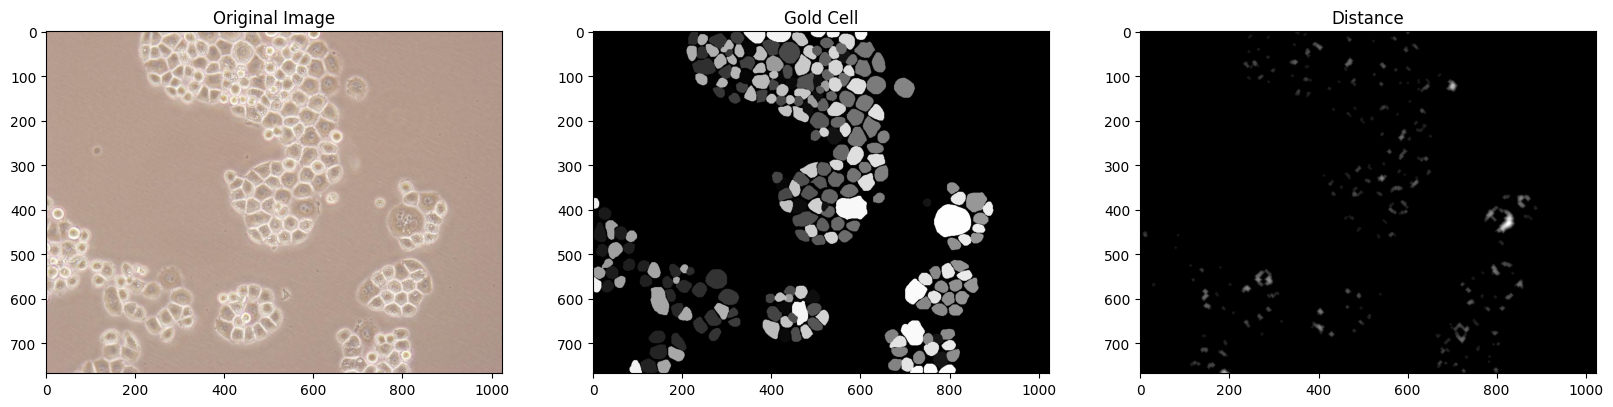

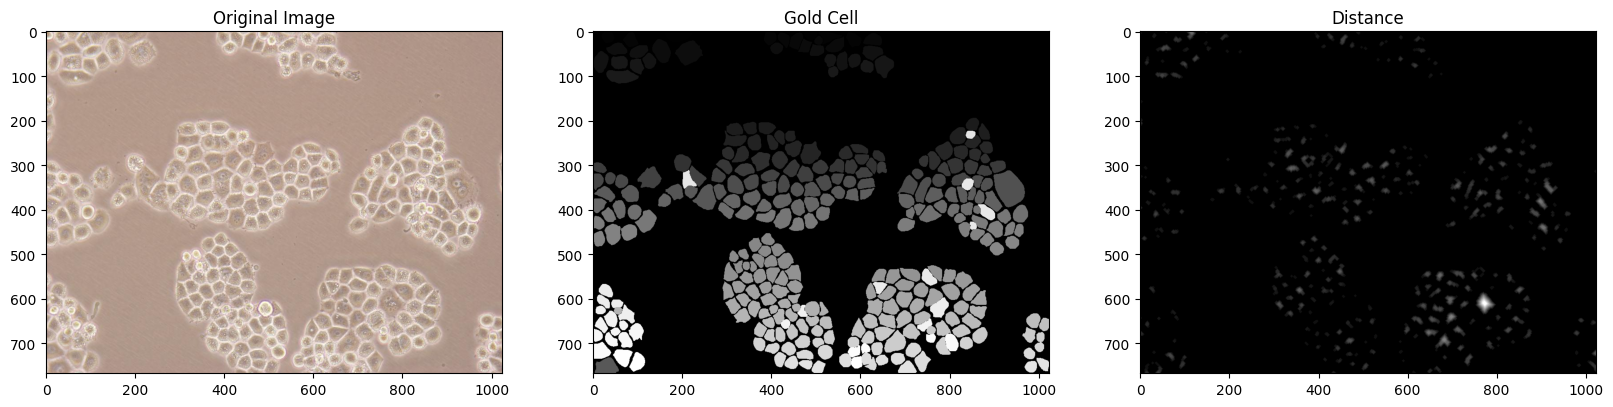

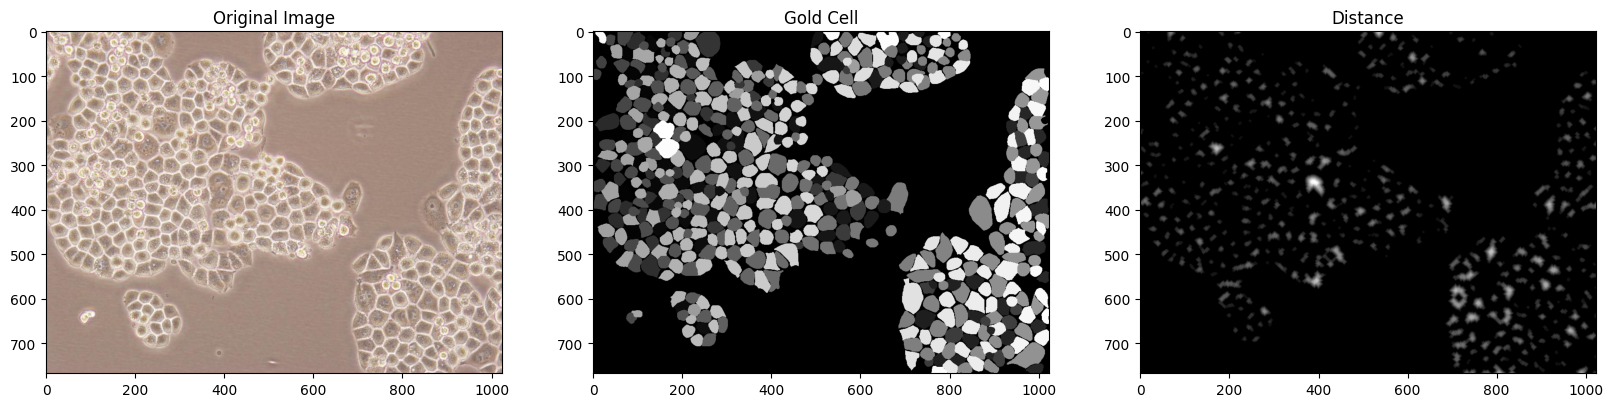

In [ ]:
im_plot_gr_cell(images['im1'], gold_cells['im1'], results['im1'][1], "im1_findcell")
im_plot_gr_cell(images['im2'], gold_cells['im2'], results['im2'][1], "im2_findcell")
im_plot_gr_cell(images['im3'], gold_cells['im3'], results['im3'][1], "im3_findcell")

In [ ]:
def cell_evaluation_metrics(gold_cell_truth, found):
    tp = np.sum((gold_cell_truth > 0) & (found == 1))
    fp = np.sum((gold_cell_truth == 0) & (found == 1))

    fn = np.max(gold_cell_truth) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [ ]:
for key in image_keys:
    cell_precision, cell_recall, cell_f1_score = cell_evaluation_metrics(gold_cells[key], xy_images[key])
    metrics[key] = {'Precision': cell_precision, 'Recall': cell_recall, 'F1 Score': cell_f1_score}
    print(f"Metrics for {key}:")
    print(f"Precision: {cell_precision:.4f}")
    print(f"Recall: {cell_recall:.4f}")
    print(f"F1 Score: {cell_f1_score:.4f}")
    print()

Metrics for im1:
Precision: 0.9695
Recall: 0.6570
F1 Score: 0.7833

Metrics for im2:
Precision: 0.9488
Recall: 0.8939
F1 Score: 0.9205

Metrics for im3:
Precision: 0.9332
Recall: 0.7682
F1 Score: 0.8427



In [ ]:
def shape_comp(next, mask, image, mark):
    height, width = image.shape[:2]
    y, x = next

    if y >= height or x >= width or mask[y, x] == 0 or image[y, x] >= 160 or mark[y, x] == 1:
        return False
    return True

In [ ]:
def region_grow(image, mask, cell, index, arr, mark):
  from queue import Queue
  mark[cell] = 1
  dirs = [[-1,0],[0,-1],[0,1],[1,0]]
  q = Queue()
  q.put((cell, 0))
  arr[cell] = index

  while not q.empty():
    first, depth = q.get()
    if depth == 40:
      continue
    for dir in dirs:
      next = (dir[0] + first[0], dir[1] + first[1])
      if (shape_comp(next, mask, image, mark)):
        mark[next] = 1
        q.put((next, depth+1))
        arr[next] = index


In [ ]:
def find_cell_boundaries(image, mask, cells):
    mask[mask == 1] = 255
    image = cv.blur(image, (5,5))
    masked_image = cv.bitwise_and(image, image, mask = mask)

    image_r_ch = masked_image[:,:,0]

    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    log_image = cv.filter2D(image_r_ch, cv.CV_32F, kernel)

    cv.normalize(log_image, log_image, 0, 255, cv.NORM_MINMAX)
    log_image = 255 - log_image
    log_image[log_image > 140] = 127
    log_image[log_image < 110] = 127
    cv.normalize(log_image, log_image, 0, 255, cv.NORM_MINMAX)

    log_image = cv.GaussianBlur(log_image, (5,5), 0)

    sharp = np.float32(image_r_ch)
    res_image = sharp + log_image

    cv.normalize(res_image, res_image, 0, 255, cv.NORM_MINMAX)
    res_image = res_image.astype('uint8')

    indices = np.zeros(res_image.shape, dtype='uint16')
    mark = np.zeros(res_image.shape, dtype='uint8')

    for i, cell in enumerate(cells, start=1):
        region_grow(res_image, mask, cell, i, indices, mark)  # Assuming region_grow is defined elsewhere

    colored_region = np.zeros((res_image.shape[0], res_image.shape[1], 3), dtype='uint8')
    colors = np.random.randint(0, 256, size=(len(cells), 3))
    for i in range(1, len(cells) + 1):
        colored_region[indices == i] = colors[i-1]

    return indices, colored_region

In [ ]:
indices_dict = {}
colored_region_dict = {}

for key, img in images.items():
    mask = foreground_masks[key]
    cells = results[key][0]

    indices_result, colored_region_result = find_cell_boundaries(img, mask, cells)

    indices_dict[key] = indices_result
    colored_region_dict[key] = colored_region_result

In [ ]:
def im_plot_color_cell(org_im, gold_cell, colored_region, file_name):

    if isinstance(gold_cell, str):
        color_map = np.loadtxt(gold_cell, dtype='uint16')
    else:
        color_map = gold_cell

    uniques = np.unique(color_map)
    rng = default_rng()
    vals = rng.integers(low=0, high=256, size=(len(uniques), 3))
    vals[0] = np.array([0, 0, 0])

    color_3d_map = color.gray2rgb(color_map)
    for i, unique in enumerate(uniques):
        color_3d_map[color_map == unique] = vals[i]
    color_3d_map = color_3d_map.astype('uint8')

    if org_im.shape[2] == 3:
        org_im = cv.cvtColor(org_im, cv.COLOR_BGR2RGB)
    if colored_region.shape[2] == 3:
        colored_region = cv.cvtColor(colored_region, cv.COLOR_BGR2RGB)

    fig = plt.figure()
    fig.set_size_inches(20, 10)

    fig.add_subplot(131)
    plt.title('Original Image')
    plt.imshow(org_im)

    fig.add_subplot(132)
    plt.title('Gold Cell')
    plt.imshow(color_3d_map)

    fig.add_subplot(133)
    plt.title('Colored Cells')
    plt.imshow(colored_region)

    plt.savefig(file_name + '.png')
    plt.show()

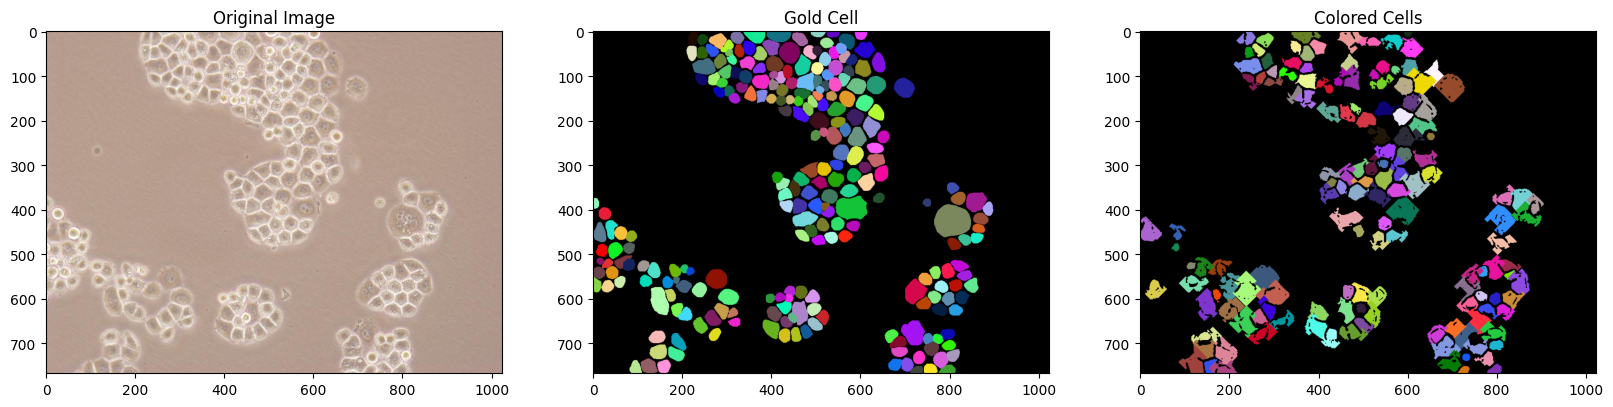

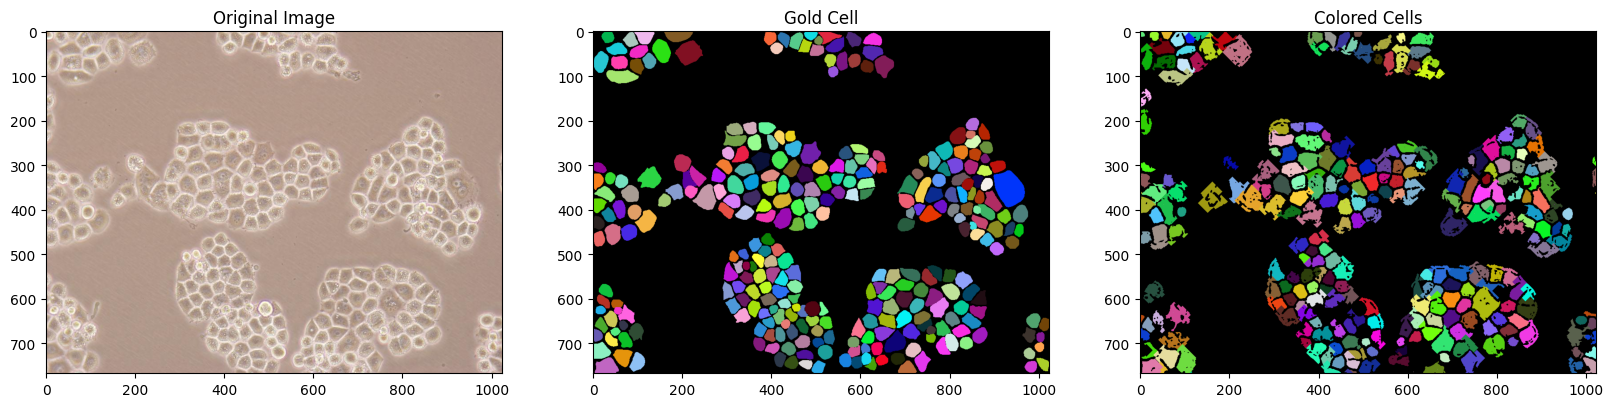

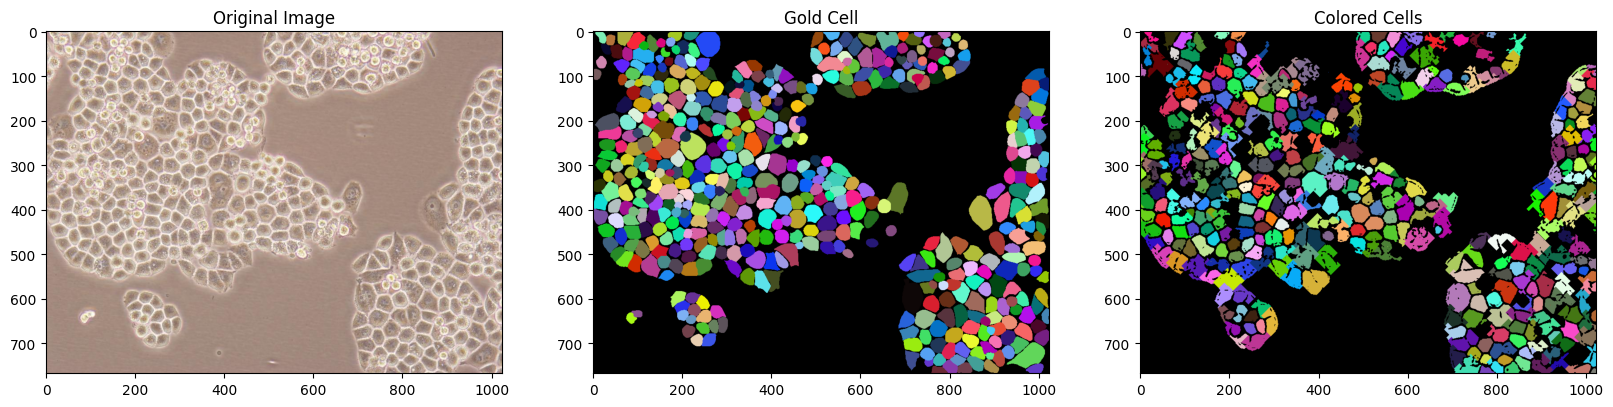

In [ ]:
im_plot_color_cell(images['im1'], gold_cells['im1'], colored_region_dict['im1'], "im1_color")
im_plot_color_cell(images['im2'], gold_cells['im2'], colored_region_dict['im2'], "im2_color")
im_plot_color_cell(images['im3'], gold_cells['im3'], colored_region_dict['im3'], "im3_color")

In [ ]:
import numpy as np

def color_tp(ground_truth, found, ratio=0.5):
    tp_cnt = 0
    unique_ground_truth = np.unique(ground_truth)
    unique_found = np.unique(found)
    mark = np.zeros_like(unique_ground_truth)

    for i in unique_found:
        marking = 0
        mx_marking = 0

        for j, gt_value in enumerate(unique_ground_truth):
            if mark[j] == 1:
                continue

            cur_res = np.sum((ground_truth == gt_value) & (found == i))
            last_union = np.sum((ground_truth == gt_value) | (found == i))

            if mx_marking < cur_res and cur_res / last_union >= ratio:
                mx_marking = cur_res
                marking = gt_value

        if marking != 0:
            mark[np.where(unique_ground_truth == marking)] = 1
            tp_cnt += 1

    return tp_cnt

def color_fp(ground_truth, found, ratio=0.5):
    tp = color_tp(ground_truth, found, ratio)
    return np.max(found) - tp

def color_fn(ground_truth, found, ratio=0.5):
    tp = color_tp(ground_truth, found, ratio)
    return np.max(ground_truth) - tp

def color_recall(ground_truth, found, ratio=0.5):
    tp = color_tp(ground_truth, found, ratio)
    return tp / np.max(found)

def color_f1_score(ground_truth, found, ratio=0.5):
    tp = color_tp(ground_truth, found, ratio)
    precision = tp / np.max(ground_truth)
    recall = tp / np.max(found)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

def color_precision(ground_truth, found, ratio=0.5):
    tp = color_tp(ground_truth, found, ratio)
    return tp / np.max(ground_truth)

def ratio(img, i):
    return np.sum(img == i) / np.sum(img != 0)

def maximal_overlap(src, dst, cur):
    src_mask = src == cur
    dst_mask = dst == cur

    overlap = np.sum(src_mask & dst_mask)
    src_sum = np.sum(src_mask)
    dst_sum = np.sum(dst_mask)

    di = 2 * overlap / (src_sum + dst_sum)
    return cur, di

def dice_index(ground_truth, found):
    res = 0
    whole_found = np.sum(found != 0)
    whole_ground = np.sum(ground_truth != 0)

    for i in np.unique(found):
        if i == 0:
            continue
        _, di = maximal_overlap(ground_truth, found, i)
        res += di * (np.sum(found == i) / whole_found)

    for i in np.unique(ground_truth):
        if i == 0:
            continue
        _, di = maximal_overlap(found, ground_truth, i)
        res += di * (np.sum(ground_truth == i) / whole_ground)
    return res / 2


In [ ]:
ratios = [0.5, 0.75, 0.9]

for key in image_keys:
    tp_dict = {}
    fp_dict = {}
    fn_dict = {}
    for ratio in ratios:
        tp = color_tp(gold_cells[key], indices_dict[key], ratio)
        fp = np.max(indices_dict[key]) - tp
        fn = np.max(gold_cells[key]) - tp

        tp_dict[ratio] = tp
        fp_dict[ratio] = fp
        fn_dict[ratio] = fn

    metrics[key] = {'TP': tp_dict, 'FP': fp_dict, 'FN': fn_dict}

# Print the metrics
for key, image_metrics in metrics.items():
    print(f"Metrics for {key}:")
    for ratio, values in image_metrics.items():
        print(f"Ratio={ratio}:")
        print(f"  Precision: {values['TP'] / (values['TP'] + values['FP']):.4f}")
        print(f"  Recall: {values['TP'] / (values['TP'] + values['FN']):.4f}")
        print(f"  F1 Score: {2 * (values['TP'] / (values['TP'] + values['FP']) * values['TP'] / (values['TP'] + values['FN'])) / (values['TP'] / (values['TP'] + values['FP']) + values['TP'] / (values['TP'] + values['FN'])):.4f}")
    print()

In [ ]:
# PART 4: SEGMENTATION OF BLOOD VESSELS IN FUNDUS PHOTOGRAPHY IMAGES

fundus_data_directory = "/content/drive/MyDrive/COMP 548 - MED IMG/Assignments/Assignment 1/fundus"

image_files = os.listdir(fundus_data_directory)

fundus_images = {}
fundus_gold_masks = {}

for image_file in image_files:
    if image_file.endswith(".jpg"):
        base_name = image_file.split('.')[0]
        gold_mask_file = base_name + "_gold.png"

        image_path = os.path.join(data_directory, image_file)
        gold_mask_path = os.path.join(fundus_data_directory, gold_mask_file)

        fundus_images[base_name] = cv.imread(image_path)
        fundus_gold_masks[base_name] = cv.imread(gold_mask_path, cv.IMREAD_GRAYSCALE)